# NYC Green Taxi Analysis

This is a detailed notebook with code and step-by-step analysis for the NYC Green Taxi Analysis. This notebook mainly has five sections corresponding to the five questions for this project. Emphasis or important terms are bolded.

## Import Packages

In [1]:
import os
# import requests 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for data visualization
# from mpl_toolkits.basemap import Basemap
# import gmplot
# import googlemaps
import seaborn as sns
import datetime as dt
# from geopy.distance import geodesic # for getting distance from lat and long
%matplotlib inline
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

Before diving into the problems, let's look at some varible meanings, which is helpful for further analysis. The reference can be found through the link https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf. We will look at features related to airports in question 3 and those related to fees in the Question 4 section.  
**VendorID**: A code indicating the LPEP provider that provided the record.  
1= Creative Mobile Technologies, LLC; 2= VeriFone Inc   
**Store_and_fwd_flag**: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  
Y= store and forward trip  
N= not a store and forward trip  
**Payment Type**: A numeric code signifying how the passenger paid for the trip.  
1= Credit card  2= Cash  3= No charge  
4= Dispute  5= Unknown  6= Voided trip   
**Trip_type**: A code indicating whether the trip was a street-hail or a dispatchthat is automatically assigned based on the metered rate in use but can be altered by the driver.  
1= Street-hail   2= Dispatch

## Question One

### 1.1 downloading/loading data

In [3]:
if os.path.exists('../green_tripdata_2015-09.csv'): # Load data if the dataset is downloaded 
    data = pd.read_csv('../green_tripdata_2015-09.csv')
else: # Download dataset otherwise
    url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
    data = pd.read_csv(url)
    data.to_csv('green_tripdata_2015-09.csv',index=False)

### 1.2 number of rows/columns

In [4]:
print('Number of rows: %s'%data.shape[0])
print('Number of columns: %s'%data.shape[1])

Number of rows: 1494926
Number of columns: 21


In [4]:
data.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type '],
      dtype='object')

## Question Two: Trip Distance

We will breifly look at some summary statistics before plotting the histogram. Some values are extreme and they may be outliers. The distance variable seems **asymmetrically** distributed and a histogram plot of cleaned data should be displayed except from one with all data. 

In [5]:
data['Trip_distance'].describe(percentiles = np.arange(0.05,1,0.2))

count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
5%       4.800000e-01
25%      1.100000e+00
45%      1.750000e+00
50%      1.980000e+00
65.0%    2.870000e+00
85.0%    5.270000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64

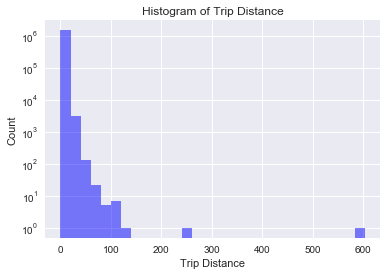

In [5]:
# histogram of trip distance
# use log of count to see the distribution
plt.hist(data['Trip_distance'],bins = 30,facecolor = 'blue',alpha =0.5)
plt.xlabel('Trip Distance')
plt.ylabel('Count')
plt.yscale('log')
plt.title('Histogram of Trip Distance')
plt.savefig('Trip_distance.jpeg',format='jpeg')
plt.show()

Then I removed the potential outliers. The potential outliers are measured as the absolute value of difference between mean is greater than 3\*std, which is **abs(x-mean)/std>3** according to **Chauvenet's criterion** to remove outliers from the Trip distance data. The distribution looks clear without those values. 

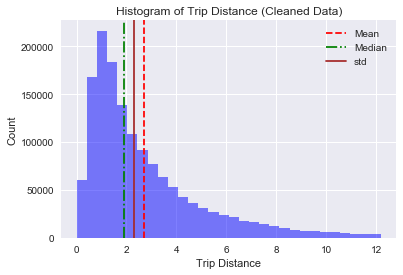

In [7]:
distance = data['Trip_distance']
clean_distance = distance[~((distance-distance.mean()).abs()>distance.std()*3)]
plt.hist(clean_distance,bins = 30,facecolor = 'blue',alpha =0.5)
# clean_distance.hist(bins=30)
plt.axvline(clean_distance.mean(),color = 'red',linestyle = '--')
plt.axvline(clean_distance.median(),color = 'green',linestyle = '-.')
plt.axvline(clean_distance.std(),color = 'brown')
plt.xlabel('Trip Distance')
plt.ylabel('Count')
plt.legend(['Mean','Median','std'])
plt.title('Histogram of Trip Distance (Cleaned Data)')
plt.savefig('trip_distance(clean).jpeg',format='jpeg')
plt.show()

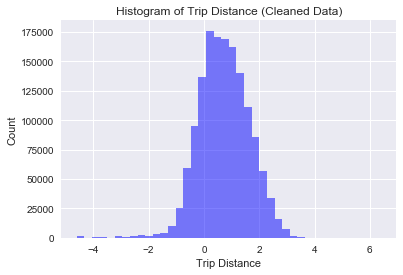

In [11]:
distance = data['Trip_distance']
clean_distance = distance[~((distance-distance.mean()).abs()>distance.std()*3)]
clean_distance = [c for c in distance if c!=0]
zeros = [c for c in distance if c==0]
plt.hist(np.log(clean_distance),bins = 40,facecolor = 'blue',alpha =0.5)
# # clean_distance.hist(bins=30)
# plt.axvline(clean_distance.mean(),color = 'red',linestyle = '--')
# plt.axvline(clean_distance.median(),color = 'green',linestyle = '-.')
# plt.axvline(clean_distance.std(),color = 'brown')
plt.xlabel('Trip Distance')
plt.ylabel('Count')
# plt.legend(['Mean','Median','std'])
plt.title('Histogram of Trip Distance (Cleaned Data)')
# plt.savefig('trip_distance(clean).jpeg',format='jpeg')
plt.show()

I also tried to explore whether 'store_and_fwd_flag' will indicate a problem in the distance record. It's hard to tell if it means a problem so I choose to keep those.

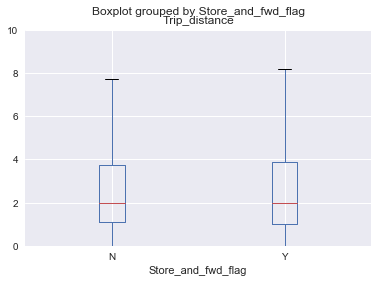

In [8]:
data.boxplot('Trip_distance',by = 'Store_and_fwd_flag')
plt.ylim(0,10)
plt.show()
y = data[data['Store_and_fwd_flag']=='Y']['Trip_distance']
n = data[data['Store_and_fwd_flag']=='N']['Trip_distance']


### Summary:
1. The histograms are shown above: one with all the data, one without potential outliers.
2. **Structure**: The Trip Distance is skewed to the right and the count of different trip distance follows **lognormal** distribution. The median is smaller than both mean and std. Most of the data are in the range of 0 to 10, which is a reasonable amount. 

    **Assumption**: The distance distribution is not random, but may follow some rules. If the distances are random generated, the distribution may follow normal distribution.

## Question Three

The hour needs to be extracted so that we can group by hour of day to compute the mean and median of trip distance. Hour information can be derived either by pickup or dropoff.  
To extract the hour information, one can either use the regular expression, or  use standard datetime format of the datetime string. I converted the string to a strptime format for the convenience of future use.

In [9]:
# Convert the the dropoff and pickup time to strptime format if not
# Derive dropoff and pickup hour from strptime
if type(data['Lpep_dropoff_datetime'][0]) ==str:
    data['Lpep_dropoff_datetime'] = data['Lpep_dropoff_datetime'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
data['dropoff_hour'] = data['Lpep_dropoff_datetime'].dt.hour
if type(data['lpep_pickup_datetime'][0])==str:
    data['lpep_pickup_datetime'] = data['lpep_pickup_datetime'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
data['pickup_hour'] = data['lpep_pickup_datetime'].dt.hour   

In [10]:
# group distance by pickup hour and aggregate to get the mean and median
pickup_dis =  data[['Trip_distance','pickup_hour']].groupby(by = 'pickup_hour',as_index = False)
pickup_dis_mm = pd.merge(pickup_dis.mean(),pickup_dis.median(), on = 'pickup_hour')
pickup_dis_mm.rename(columns = {'Trip_distance_x':'mean','Trip_distance_y':'median'},inplace = True)
# group by dropoff hour
dropoff_dis = data[['Trip_distance','dropoff_hour']].groupby(by = 'dropoff_hour', as_index = False)
dropoff_dis_mm = pd.merge(dropoff_dis.mean(),dropoff_dis.median(), on = 'dropoff_hour')
dropoff_dis_mm.rename(columns = {'Trip_distance_x':'mean','Trip_distance_y':'median'}, inplace = True)
print(pickup_dis_mm)
print(dropoff_dis_mm)

    pickup_hour      mean  median
0             0  3.115276    2.20
1             1  3.017347    2.12
2             2  3.046176    2.14
3             3  3.212945    2.20
4             4  3.526555    2.36
5             5  4.133474    2.90
6             6  4.055149    2.84
7             7  3.284394    2.17
8             8  3.048450    1.98
9             9  2.999105    1.96
10           10  2.944482    1.92
11           11  2.912015    1.88
12           12  2.903065    1.89
13           13  2.878294    1.84
14           14  2.864304    1.83
15           15  2.857040    1.81
16           16  2.779852    1.80
17           17  2.679114    1.78
18           18  2.653222    1.80
19           19  2.715597    1.85
20           20  2.777052    1.90
21           21  2.999189    2.03
22           22  3.185394    2.20
23           23  3.191538    2.22
    dropoff_hour      mean  median
0              0  3.239356    2.28
1              1  3.130531    2.20
2              2  3.143715    2.21
3         

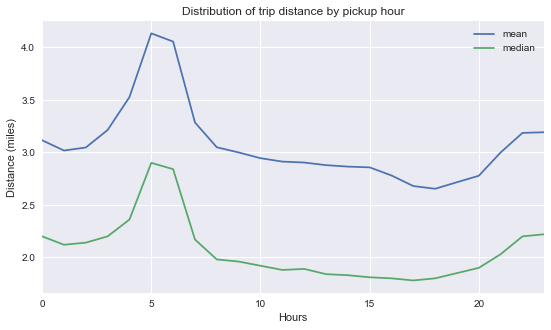

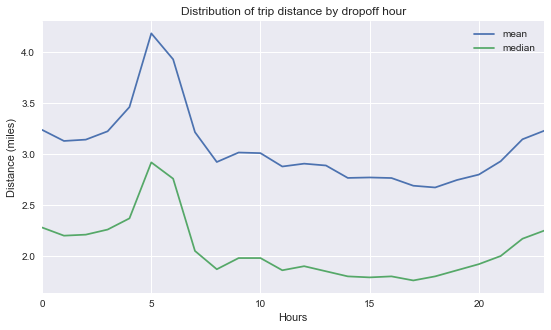

In [11]:
def plot(data,s):
    '''''
    Plot for distance mean/ median by hour
    data: aggregated data
    s: 'pickup' or 'dropoff'
    '''''
    fig,ax = plt.subplots(1,1,figsize=(9,5)) 
    data[['mean','median']].plot(ax=ax)
    plt.ylabel('Distance (miles)')
    plt.xlabel('Hours')
    plt.title('Distribution of trip distance by %s hour'%s)
    plt.xlim([0,23])
    plt.savefig('%s.jpeg'%s,format='jpeg')
    plt.show()
plot(pickup_dis_mm,'pickup')
plot(dropoff_dis_mm,'dropoff')

From the above plots, there are two peaks at hour 0,5 and from 22 to 7 the mean distance tends to be greater than other times. The median is smaller than the mean at all times which indicates a right skewness. 

### 3.2 Airports rides

**Assumptions**: 
    1. The areacode is accurate and the pickup/dropoff coordinate is also accurate.
    2. Those transactions picked up at JFK/Newark are not recorded at RateCodeID. Some trips picked up or dropped off very close to JKF/Newark may not be counted in the RateCodeId as 2/3.
    3. **RateCodeID**: The final rate code in effect at the end of the trip.   
        1= Standard rate  2=JFK  3=Newark  
        4=Nassau or Westchester  5=Negotiated fare  6=Group ride 

**Analysis**:   
There are **three main airports** in New York. The latitude and longitude for Laguardia Airport is (40.7769° N, 73.8740° W), for JFK is (40.6413° N, 73.7781° W) and for Newark Liberty International Airport is (40.6895° N, 74.1745° W).  To find those who depart or arrive at the airport, we may use the information of **RateCodeID** (2,3 for JFK and Newark). Those with ratecode as 2 or 3 means trips end at Newark or JFK.   
Otherwise, the **pickup or dropoff latitude and longitude** may also be used to identify trips originate or terminate at one of the NYC airports. I will use a rectanguar to capture the area of airports. A approximate square for the three airports are listed below:   

 - Laguardia Airport: (40.7675, 40.773) (-73.885, -73.865)  
 - JFK Airport: (40.6467, 40.6665) (-73.8219, -73.7503)  
 - Newark Airport: (40.675, 40.708) (-74.180, -74.155)  
 
An oval may be better to caputure the area but hard to calculate. There are 5552 transactions which end up at JFK or Newark. Among those dropped off at JFK/Newark, some may be picked up at another airport, so we don't want to count those twice.


In [12]:
#get those with RatecodeID of 2 or 3
jfk_newark_d = data[(data['RateCodeID']==2) | (data['RateCodeID']==3)]
data_ = data[(data['RateCodeID']!=2) & (data['RateCodeID']!=3)]
jfk_newark_d.shape

(5552, 23)

In [13]:
p_lgd = data_[(data_['Pickup_latitude'].between(40.7675, 40.773))& (data_['Pickup_longitude'].between(-73.885,-73.865))]
p_jfk = data_[(data_['Pickup_latitude'].between(40.6467, 40.6665)) & (data_['Pickup_longitude'].between(-73.8219, -73.7503))]
p_nwk = data_[(data_['Pickup_latitude'].between(40.672, 40.708)) & (data_['Pickup_longitude'].between(-74.180, -74.155))]
d_lgd = data_[(data_['Dropoff_latitude'].between(40.7675, 40.773)) & (data_['Dropoff_longitude'].between(-73.885,-73.865))]
d_jfk = data_[(data_['Dropoff_latitude'].between(40.6467, 40.6665)) & (data_['Dropoff_longitude'].between(-73.8219, -73.7503))]
d_nwk = data_[(data_['Dropoff_latitude'].between(40.672, 40.708)) & (data_['Dropoff_longitude'].between(-74.180, -74.155))]
print(len(p_lgd),len(p_jfk),len(p_nwk),len(d_lgd),len(d_jfk),len(d_nwk))

624 193 28 5974 3923 221


In [14]:
# get all possible transactions that meet the requirement 
airport = data[(data['Pickup_latitude'].between(40.7675, 40.773))& (data['Pickup_longitude'].between(-73.885,-73.865))|
               (data['Pickup_latitude'].between(40.6467, 40.6665)) & (data['Pickup_longitude'].between(-73.8219, -73.7503))|
               (data['Pickup_latitude'].between(40.672, 40.708)) & (data['Pickup_longitude'].between(-74.180, -74.155))|
               (data['Dropoff_latitude'].between(40.7675, 40.773)) & (data['Dropoff_longitude'].between(-73.885,-73.865))|
               (data['Dropoff_latitude'].between(40.6467, 40.6665)) & (data['Dropoff_longitude'].between(-73.8219, -73.7503))|
               (data['Dropoff_latitude'].between(40.672, 40.708)) & (data['Dropoff_longitude'].between(-74.180, -74.155))|
               (data['RateCodeID']==2) | (data['RateCodeID']==3)
              ]

In [15]:
print('The rough count of trips that originate or terminate at one of the NYC area airports is %s'%airport.shape[0])
print('The mean of fare amount of trips that originate or terminate at one of the NYC area airports is %s'%airport['Fare_amount'].mean())
print('The mean of total fare of trips that originate or terminate at one of the NYC area airports is %s'%airport['Total_amount'].mean())
print('The mean of fare amount of all trips is %s'%data['Fare_amount'].mean())
print('The mean of total fare of all trips is %s'%data['Total_amount'].mean())
print('The mean of fare amount of trips using area code 2/3 is %s'%jfk_newark_d['Fare_amount'].mean())
print('The mean of total fare of trips using area code 2/3 is %s'%jfk_newark_d['Total_amount'].mean())

The rough count of trips that originate or terminate at one of the NYC area airports is 16296
The mean of fare amount of trips that originate or terminate at one of the NYC area airports is 33.497535591556215
The mean of total fare of trips that originate or terminate at one of the NYC area airports is 39.463142488955384
The mean of fare amount of all trips is 12.54319751613129
The mean of total fare of all trips is 15.032145751981083
The mean of fare amount of trips using area code 2/3 is 48.976945244956774
The mean of total fare of trips using area code 2/3 is 57.20842038904719


**Summary and Finding:**
    1. There are around 16296 trips that originate or terminate at one of the NYC area airports. The mean fare of those trips are 33.4975 and mean total fee is 39.463.
    2. From the above statitics, there are more dropoffs than pickups in all three airports, which means people may prefer using other transportations after arriving at an airports, or there are simply more people flying from NYC to other places than flying to NYC.
    3. The average fees is more than twice of the average fees of all trips. There are two possible reasons for this: The trips from or to the airports are generally longer than other trips as the fare amount is also higher; the trips from or to the airports are generally more expensive and the total fee will include high subcharges (trips to Newark) or high base fee (trip between manhattan and JFK.

## Question 4

**Tip_amount**: Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.  
**Total_amount**: The total amount charged to passengers. Does not include cash tips.

### 4.1 Create tip as percentage of total fare

 - create and show summary statistics of relevant features.

In [16]:
data['tip_perc'] = data['Tip_amount']/data['Total_amount']*100
print(data[['Tip_amount','Total_amount','tip_perc']].describe())

         Tip_amount  Total_amount      tip_perc
count  1.494926e+06  1.494926e+06  1.490754e+06
mean   1.235727e+00  1.503215e+01  6.653826e+00
std    2.431476e+00  1.155316e+01  8.875158e+00
min   -5.000000e+01 -4.750000e+02  0.000000e+00
25%    0.000000e+00  8.160000e+00  0.000000e+00
50%    0.000000e+00  1.176000e+01  0.000000e+00
75%    2.000000e+00  1.830000e+01  1.666667e+01
max    3.000000e+02  5.813000e+02  1.000000e+02


Plot a distribution of Tip Percentage as well as tip amount

C:\Users\Jianqiu Kong\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\Jianqiu Kong\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


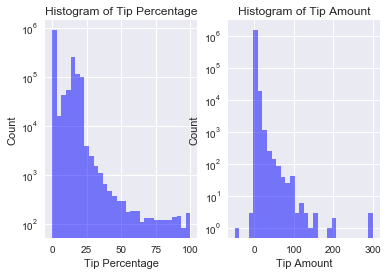

In [54]:
fig, ax = plt.subplots(1,2)
ax[0].hist(data['tip_perc'],bins = 30, facecolor='blue',alpha = 0.5)
ax[0].set_xlabel('Tip Percentage')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('Histogram of Tip Percentage')
ax[1].hist(data['Tip_amount'],bins = 30, facecolor='blue',alpha = 0.5)
ax[1].set_xlabel('Tip Amount')
ax[1].set_ylabel('Count')
ax[1].set_yscale('log')
ax[1].set_title('Histogram of Tip Amount')
plt.savefig('histo.jpeg')
plt.show()

plot two histogram by different methods

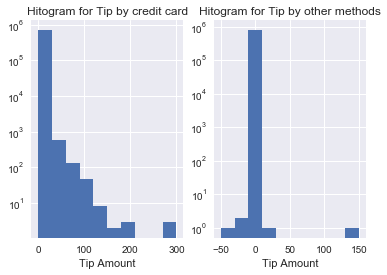

In [18]:
def plot_tip(data):
    fig, ax = plt.subplots(1,2)
    label = list(set(data['Payment_type']))
    ax[0].hist(data[data['Payment_type']==1]['Tip_amount'],  histtype='bar')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('Tip Amount')
    ax[0].set_title('Hitogram for Tip by credit card')
    ax[1].hist(data[data['Payment_type']!=1]['Tip_amount'],  histtype='bar')
    ax[1].set_xlabel('Tip Amount')
    ax[1].set_yscale('log')
    ax[1].set_title('Hitogram for Tip by other methods')
    plt.show()
plot_tip(data)

In [19]:
print('Tip amount by other methods:')
print('*'*60)
print('Tip by cash : %s'%set(data[data['Payment_type']==2]['Tip_amount']))
print('Tip by No charge : %s'%set(data[data['Payment_type']==3]['Tip_amount']))
print('Tip by Dispute : %s'%set(data[data['Payment_type']==4]['Tip_amount']))
print('Tip by void : %s'%set(data[data['Payment_type']==5]['Tip_amount']))

Tip amount by other methods:
************************************************************
Tip by cash : {0.0, 13.26, 150.0}
Tip by No charge : {0.0, -0.82, -0.76, -0.99, -0.66, -0.63, -1.14, -12.3, -11.2, -1.0, -2.7, -2.2, -1.29, -5.0, -3.0, -2.4, -1.7}
Tip by Dispute : {0.0, -0.66, 3.95, -50.0}
Tip by void : {0.0}


**Analysis**:  
From the description above, we can see that over 50% of the trips had no tip recorded, there are several reasons. For those who paid tip with cash, the cash will not be recorded in the Tip_amount. The relationship between tip and payment type will be explored in the next subsection. There are also tip amount values that are extremely large like \$200, these may be caused by mistake or some error or just good luck. The tip and total amount have some out-of-range values which is smaller than the theoratical minimum value.   
    **Tip amount** should be equal to or greater than 0 while some existing values are smaller than 0. 
    **Total Amount** should be at least a base fee which is \$2.5 as mentioned in reference [3]. Those have a negative tip amount also have a negative of total amount. We may assume that those with 0 or negative total amount transactions are not actually made or these is dispute, therefore, **those rows with out-of-range values (negative tip, too small total amount) should be filtered out**. For transactions made by credit card, no negative tips are recorded. The filtered data will then be used for further analysis and now we have 1487767 observations. A very large amount of tip is also suspicious, whether it is due to good luck, a mistake or anything else.  

**Assumptions**:
 - I assumed that those transactions with zero total fare are not made successfully 
 - Those with negative fare and tip values are outliers, not postive values recorded by mistake

**Further Processing**:   
I dropped those negative tip amount as well as those total amount less than 2.5

In [20]:
clean_data = data[(data['Total_amount']>=2.5)& (data['Tip_amount']>=0) ]
clean_data.shape

(1487767, 24)

### 4.2 Data Processing and Model Building

#### Explortary Data Analysis

**Fare_amount**： The time-and-distance fare calculated by the meter.  
**Extra**： Miscellaneous extras and surcharges. Currently, this only includes the 0.50 and 1 rush hour and overnight charges.  
**MTA_tax**: 0.50 MTA tax that is automatically triggered based on the metered rate in use.  
**Improvement_surcharge**: 0.30 improvement surcharge assessed on hailed trips at the flag drop. The improvement surcharge began being levied in 2015.  
**Tolls_amount**: Total amount of all tolls paid in trip.  


In [21]:
#check for missing values
print(clean_data.isna().sum())

VendorID                       0
lpep_pickup_datetime           0
Lpep_dropoff_datetime          0
Store_and_fwd_flag             0
RateCodeID                     0
Pickup_longitude               0
Pickup_latitude                0
Dropoff_longitude              0
Dropoff_latitude               0
Passenger_count                0
Trip_distance                  0
Fare_amount                    0
Extra                          0
MTA_tax                        0
Tip_amount                     0
Tolls_amount                   0
Ehail_fee                1487767
improvement_surcharge          0
Total_amount                   0
Payment_type                   0
Trip_type                      4
dropoff_hour                   0
pickup_hour                    0
tip_perc                       0
dtype: int64


In [22]:
# check for out-of-range values
print(clean_data[['Fare_amount','Extra','MTA_tax','improvement_surcharge','Tolls_amount']].describe())
print("*"*60)
print("unique values of trip types: %s"%set(clean_data['Trip_type ']))
print("unique values of payment types: %s"%set(clean_data['Payment_type']))
print("unique values of passenger count: %s"%set(clean_data['Passenger_count']))
print("unique values of rateCodeID: %s"%set(clean_data['RateCodeID']))

        Fare_amount         Extra       MTA_tax  improvement_surcharge  \
count  1.487767e+06  1.487767e+06  1.487767e+06           1.487767e+06   
mean   1.261998e+01  3.535114e-01  4.896264e-01           2.938946e-01   
std    9.976052e+00  3.653123e-01  7.126845e-02           4.235968e-02   
min    0.000000e+00 -7.200000e-01  0.000000e+00           0.000000e+00   
25%    6.500000e+00  0.000000e+00  5.000000e-01           3.000000e-01   
50%    9.500000e+00  5.000000e-01  5.000000e-01           3.000000e-01   
75%    1.550000e+01  5.000000e-01  5.000000e-01           3.000000e-01   
max    5.805000e+02  1.200000e+01  5.000000e-01           3.000000e-01   

       Tolls_amount  
count  1.487767e+06  
mean   1.237030e-01  
std    8.928306e-01  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    9.575000e+01  
************************************************************
unique values of trip types: {nan, 1.0, 2.0, nan, nan, nan}
unique values 

The following situations are detected:   
**Ehail_fee**: This feature is completely missing, so this feature will be deleted.   
**Trip type**: Missing values will be imputed by the mode.   
**RateCodeID**: It has a code 99 which is not in the list which should mean missing, will be replaced by mode  
**Fare_amount, Extra, MTA_amount, Tolls_fee, improvement_subcharges**: should all be at least 0, Extra still have negative values.    
These conditions will be corrected in the data cleaning section. 

** Data Cleaning**

In [23]:
def clean(data):
    newdata = data.copy(deep = True)
    # drop the Ehail_fee column as 100% is missing and other features
    if 'Ehail_fee' in newdata.columns:
        newdata.drop(['Ehail_fee'],axis=1,inplace=True)
    newdata['Trip_type '].fillna(newdata['Trip_type '].mode()[0], inplace = True) #impute missing trip type using the mode
    newdata['Extra'] = newdata['Extra'].apply(lambda x:0 if x<0 else x)  #replace negative extra values with 0
    newdata['RateCodeID'] = newdata['RateCodeID'].apply(lambda x: 1 if x==99 else x) #replace 99 with 1
    
    print('Data Cleaning Done')
    return newdata

**Feature Engineering**  
Some features are hard to utilize directly, like pickuptime and location information, I will transform those features to usable features that can be fit in the model and drop the original ones. 
I created the following features from existing variables, speed and duration are features from question five.
    1. day of week : Monday-Sunday
    2. hour of day: which hour during the day
    3. Speed: average speed by mph 
    4. Duration: The trip duration
    5. airport: Measure whether the trips originate or terminate at one of the NYC area airports
    (6. manhatten: Measure whether the trips originate or terminate at Mahatten)


In [24]:
def airport(data):
    a = ((data['Pickup_latitude'].between(40.7675, 40.773)& data['Pickup_longitude'].between(-73.885,-73.865))|\
            (data['Pickup_latitude'].between(40.6467, 40.6665)) & (data['Pickup_longitude'].between(-73.8219, -73.7503))|\
            (data['Pickup_latitude'].between(40.672, 40.708)) & (data['Pickup_longitude'].between(-74.180, -74.155))|\
            (data['Dropoff_latitude'].between(40.7675, 40.773)) & (data['Dropoff_longitude'].between(-73.885,-73.865))|\
            (data['Dropoff_latitude'].between(40.6467, 40.6665)) & (data['Dropoff_longitude'].between(-73.8219, -73.7503))|\
            (data['Dropoff_latitude'].between(40.672, 40.708)) & (data['Dropoff_longitude'].between(-74.180, -74.155))|\
            (data['RateCodeID']==2) | (data['RateCodeID']==3))
    return a
# manhattan = (40.7831, -73.9712)
# def man(row):
#     if geodesic((row['Dropoff_latitude'],row['Dropoff_longitude']),manhattan).miles<=5 or\
#     geodesic((row['Pickup_latitude'],row['Pickup_longitude']),manhattan).miles<=5:
        
#         return 1
#     else:
#         return 0
    
def fe(newdata):
    if 'Lpep_dropoff_datetime' in newdata.columns:
        print('getting time related variable')
        newdata['weekday'] = newdata['lpep_pickup_datetime'].dt.dayofweek
        #get duration by minutes
        newdata['duration'] = (newdata['Lpep_dropoff_datetime']-newdata['lpep_pickup_datetime']).apply(lambda x:x.total_seconds()/3600.)
        newdata = newdata.drop(['lpep_pickup_datetime','Lpep_dropoff_datetime'],axis= 1)
    print('getting speed')
    #get speed by mph
    newdata['speed'] = newdata['Trip_distance']/(newdata['duration'])
    idx = newdata[(newdata['speed'].isna()) | (newdata['speed']>85)].index
    norm_speed = newdata[newdata['speed']<=85]['speed']
    newdata.loc[idx,'speed'] = np.random.normal(norm_speed.mean(),scale=norm_speed.std(),size=len(idx))
    newdata['Passenger_count'] = newdata['Passenger_count'].apply(lambda x: 7 if x>7 else x)
    #get whether pickup or dropoff is in airports
    print('getting location')
    #drop location information
    if 'Pickup_latitude' in newdata.columns:
        newdata['airports'] = airport(data)
        newdata.drop(['Dropoff_latitude','Dropoff_longitude','Pickup_latitude','Pickup_longitude'],axis = 1,inplace=True)
    #get whether pickup or dropoff is in manhattan
#         newdata['manhattan'] = newdata.apply(man,axis = 1)
    return newdata

In [25]:
newdata = clean(clean_data)
newdata = fe(newdata)

Data Cleaning Done
getting time related variable
getting speed
getting location


#### Feature Selection

In [26]:
newdata.columns

Index(['VendorID', 'Store_and_fwd_flag', 'RateCodeID', 'Passenger_count',
       'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount',
       'Tolls_amount', 'improvement_surcharge', 'Total_amount', 'Payment_type',
       'Trip_type ', 'dropoff_hour', 'pickup_hour', 'tip_perc', 'weekday',
       'duration', 'speed', 'airports'],
      dtype='object')

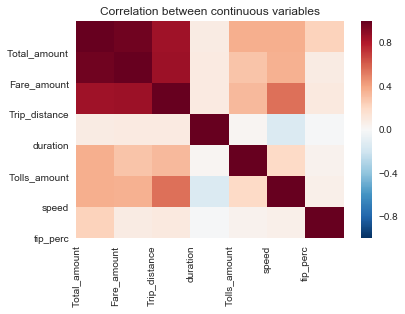

In [28]:
#explore between continuous variables
variables=['Total_amount','Fare_amount','Trip_distance','duration','Tolls_amount','speed','tip_perc']
cor_mat = newdata[variables].corr()
sns.heatmap(cor_mat)
plt.xticks(range(len(variables)),variables.reverse())
plt.yticks(range(len(variables)),variables)
plt.title('Correlation between continuous variables')
plt.savefig('corr.jpeg')
plt.show()

It seems that Total amount, fare_amount and duration are having heaviest correlation with tip_pec which suggest little linear relationship among the predictors and Tip_percent. I will use tree based models to capture a nonlinear relationship. Fare_amount, Trip_amount and Total_amount are highly correlated. This suggests that longer trip will bring more revenue. I will use Total amount to represent all other amounts.

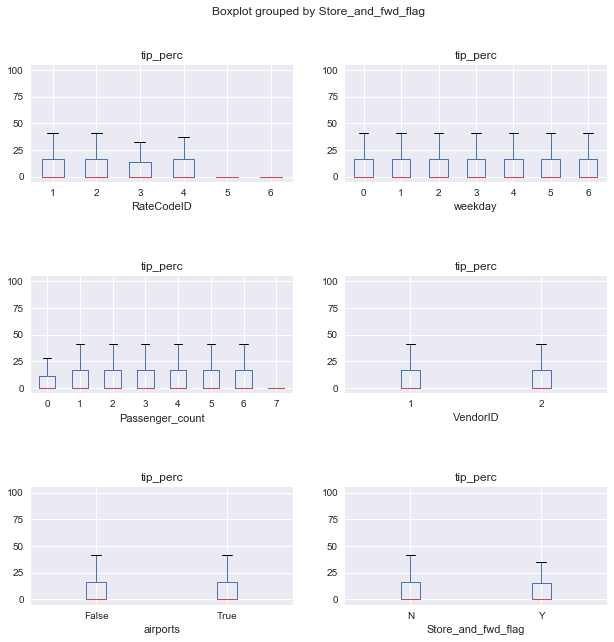

In [29]:
#exploration among catergorical features
fig, ax = plt.subplots(3,2,figsize=(10, 10))
fig.subplots_adjust(wspace=.2, hspace=.8)

cat_list =['RateCodeID',  
           'weekday', 'Passenger_count','VendorID','airports','Store_and_fwd_flag']

for i, var in enumerate(cat_list):
    c= int(i/2)
    r = (i+2) % 2
    newdata.boxplot('tip_perc',by = var,ax = ax[c][r])
    plt.savefig('boxplot.jpeg')

In [30]:
newdata.drop(['Fare_amount','MTA_tax','Extra','Tip_amount','improvement_surcharge','Tolls_amount'],axis = 1, inplace = True)

In [31]:
newdata.columns

Index(['VendorID', 'Store_and_fwd_flag', 'RateCodeID', 'Passenger_count',
       'Trip_distance', 'Total_amount', 'Payment_type', 'Trip_type ',
       'dropoff_hour', 'pickup_hour', 'tip_perc', 'weekday', 'duration',
       'speed', 'airports'],
      dtype='object')

**factorize categories**

In [32]:
categorical_features = [
    _f for _f in newdata.columns
    if  (newdata[_f].dtype == 'object')
]
for f in categorical_features:
    newdata[f], indexer = pd.factorize(newdata[f])

In [33]:
#check for missing and drop dulicate if applicable
print(newdata.isna().sum().sum())
newdata.drop_duplicates(inplace = True)

0


#### Feature Summary
Only those transactions made with credit card should have a recorded tip amount and others will not be used for training a model according to the previous result. This also decrease training as using those transactions made with other payment types will add to computational cost but yield no real improvement on prediction.

I will be using the following features for prediction: 

       VendorID, RateCodeID, Passenger_count, Trip_distance, Total_amount, Trip_type, dropoff_hour, pickup_hour, weekday, duration, speed, airports, Storage_and_fwd_flag
       

In [34]:
newdata = newdata[newdata['Payment_type']==1]
print(newdata.shape)
y = newdata['tip_perc']
x = newdata.drop(['tip_perc','Payment_type'],axis = 1)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 45)

(700149, 15)


**Model Building**

In [35]:
def gcv(xtrain,ytrain):
    cv = KFold(3)
    param_grid = {'n_estimators':(75,100,130)}
    rf = RandomForestRegressor(n_jobs=-1)
    clf = GridSearchCV(estimator=rf,param_grid=param_grid, cv=cv)
    clf.fit(xtrain,ytrain)
    return clf
# clf = gcv(xtrain, ytrain)

The best parameter from the cross validation is 130

In [37]:
# retrain the model on the training using best param
rf = RandomForestRegressor(n_estimators = 130,n_jobs=-1)
rf.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [38]:
#prediction and evaluation
y_pred = rf.predict(xtest)
mean_squared_error(y_pred, ytest)

8.3706846201708363

Feature ranking:
1. feature Total_amount (0.457169)
2. feature duration (0.241665)
3. feature Trip_distance (0.162660)
4. feature RateCodeID (0.035772)
5. feature pickup_hour (0.026755)
6. feature speed (0.024932)
7. feature dropoff_hour (0.018662)
8. feature weekday (0.016422)
9. feature VendorID (0.005809)
10. feature Trip_type  (0.004829)
11. feature Passenger_count (0.003773)
12. feature airports (0.001319)
13. feature Store_and_fwd_flag (0.000232)


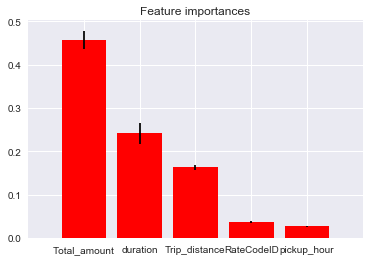

In [76]:
cols = x.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, cols[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(5), importances[indices][:5],
       color="r", yerr=std[indices][:5], align="center")
plt.xticks(range(5), [cols[i] for i in indices][:5])
plt.xlim([-1, 5])
plt.savefig('fi.jpeg')
plt.show()

From the feature importance plot by random forest, we can determine the top five factors that affect the tip percentage: Total_amount, duration, Trip_distance, RateCodeID, and pickup_hour. While Total_amount, duration, trip distance are positively related. 

#### Summary:
I have done a data processing step including data cleaning, feature engineering and feature selection. 13 final features are used for prediction. The final model is a RandomForestRegressor with 130 tree and other parameters as default. The total transactions that paid using credit card are splitted into train and test set by the ratio of 7:3. The evaluation metric is mean sqaure error. MSE on the test data is 8.355 as reported above. The prediction for transactions made with other payment methods will always be zero supposing that cash tips are not recorded in the system.

While the trip distance looks so important for a tip percentage, so other factors lead to a logner distance will be more profitable to drivers.

## Question 5 Distribution

### 5.1  Build a derived variable for speed

In [39]:
#calculate the duration, measured by hour
data_ = data.copy()
data_['duration'] = (data_['Lpep_dropoff_datetime'] - data_['lpep_pickup_datetime']).apply(lambda x: x.total_seconds()/3600.) 
data_['duration'].describe()
#calculate the speed, measured by mph
data_['speed'] = data_['Trip_distance']/data_['duration']
data_['speed'].describe()

count    1.493989e+06
mean              inf
std               NaN
min      0.000000e+00
25%      9.313761e+00
50%      1.176820e+01
75%      1.506608e+01
max               inf
Name: speed, dtype: float64

Speed has infinite values due to divide by zero operations. Meanwhile, due to a speed limit, I dropped those higher than 85 mph according to the USA speed limit[5].  Around 4000 instances are dropped.

In [40]:
#keep those speed within 85 mph and drop missing values
data_ = data_[data_['speed']<=85]
data_.shape

(1490771, 26)

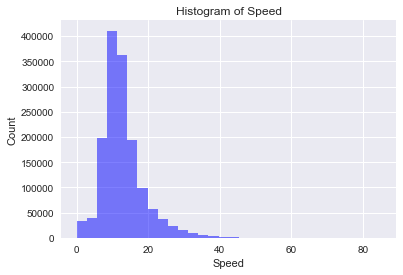

In [41]:
plt.hist(data_['speed'],bins = 30,facecolor = 'blue',alpha =0.5)
plt.xlabel('Speed')
plt.ylabel('Count')
plt.title('Histogram of Speed')
plt.savefig('speed.jpeg',format='jpeg')
plt.show()

### 5.2 Speed test

get a new feature representing the number of week in September

In [42]:
#get the week number(in a year) in Sepmtember
data_['week'] = data_['lpep_pickup_datetime'].apply(lambda x:x.isocalendar()[1])

In [43]:
#get mean and median speed by week
speed = data_[['week','speed']].groupby('week',as_index = False)
std = data_[['week','speed']].groupby('week').std()
speed_by_week = pd.merge(speed.mean(),std, on = 'week')
speed_by_week.rename(columns={'speed_x':'mean_speed','speed_y':'std_speed'},inplace=True)

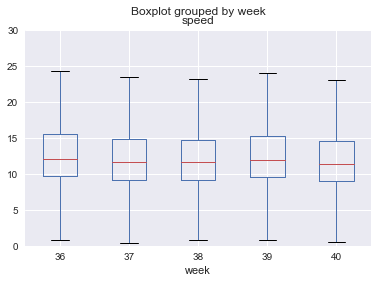

In [44]:
#boxplot of speed by week
data_.boxplot('speed',by= 'week')
plt.ylim(0,30)
plt.savefig('speedbyweek.jpeg')
plt.show()
weeks = []
for i in range(36,41):
    weeks.append(data_[data_['week']==i]['speed'])

#### Hypothesis Testing:
     Null Hypothesis:  The average trip speeds are materially the same in all weeks of September.  
  I will be using *one way ANOVA* ( technique that can be used to compare means of two or more samples) to measure and test for the null hypothesis.
#### Assumption:
    - The samples are independent. (Statisfied)
    - Each sample is from a normally distributed population.
    - The population standard deviations of the groups are all equal. This property is known as homoscedasticity.


In [45]:
# check assumptions, normalty:
print('Checking the Normalty of different groups:\n')

for w in weeks:
    print(stats.normaltest(w))
#check assumptions, homoscedasticity:
print('*'*60)
print('Checking the homoscedasticity:\n')
print(speed_by_week)

Checking the Normalty of different groups:

NormaltestResult(statistic=101021.10316743306, pvalue=0.0)
NormaltestResult(statistic=123482.56952085817, pvalue=0.0)
NormaltestResult(statistic=132146.79431265392, pvalue=0.0)
NormaltestResult(statistic=113681.96431945427, pvalue=0.0)
NormaltestResult(statistic=48895.863119247762, pvalue=0.0)
************************************************************
Checking the homoscedasticity:

   week  mean_speed  std_speed
0    36   13.262627   6.058300
1    37   12.601001   5.967376
2    38   12.602861   5.857326
3    39   13.075347   6.042444
4    40   12.408672   5.860216


#### One way Anova
   The assumptions of one way anova are checked above, the homoscedasticity can be seen as roughly satisfied. It should be safe to use one way anova. The results of comparing among two groups are shown below.

In [49]:
print('pairs | F-score | p-value')
for i in range(len(weeks)):
    for j in range(i+1,len(weeks)):
        week = "week_"+str(i+1)+"_"+str(j+1)
        #getting F statistics and p value
        F, p = stats.f_oneway(weeks[i], weeks[j])
        print(week+' | '+str(F)+' | '+str(p))
print('*'*60)
F, p = stats.f_oneway(weeks[0],weeks[1],weeks[2],weeks[3],weeks[4])
print('statistics among all weeks: F statistics: %s p values:%s'%(F,p))

pairs | F-score | p-value
week_1_2 | 1986.46774986 | 0.0
week_1_3 | 2005.11560412 | 0.0
week_1_4 | 151.931423175 | 6.61913990315e-35
week_1_5 | 1852.62319546 | 0.0
week_2_3 | 0.0178735779959 | 0.893646088486
week_2_4 | 1092.97691386 | 1.69990123374e-239
week_2_5 | 101.381309374 | 7.62791080637e-24
week_3_4 | 1099.21361256 | 7.55191290219e-241
week_3_5 | 105.925023275 | 7.70254220051e-25
week_4_5 | 1173.65797178 | 6.73768848245e-257
************************************************************
statistics among all weeks: F statistics: 962.909601227 p values:0.0


According from the results above, I may reject the null hypothesis that The average trip speeds are materially the same in all weeks of September. It is also interesting to note that among the pairwise anova test, week 2 and week 3 tend to come from a same distribution. Overall, the one_way ANOVA among five weeks indicates that the mean of the five groups are significantly different.

Note: The result may vary when using different speed limits.

**Explanation for speed variation**:  

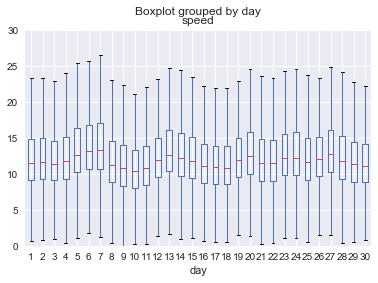

In [50]:
#plot the boxplot for the speed by day
data_['day'] = data_['lpep_pickup_datetime'].dt.day
data_.boxplot('speed',by = 'day')
plt.ylim(0,30)
plt.savefig('speedbyday.jpeg')
plt.show()

Assume that Workdays are busy, the taxis tend to be slower than weekends as people commutes between home and work and this can be supported by the boxplot above. My Explanation for the variation is as follows:    

    Week 1: Week 1 contains 6 days except for Monday, and people were travelling out of city or spending their weekends at home which makes the speed generally higher as fewer people were driving on the road. 
    
    Week 2: A decrease in mean can be noticed, this may be caused by a traffic jam after the three day holiday.
    
    Week 3: Looks like a normal week in September.
    
    Week 4: This week should be a normal, but the average speed tend to be higher, I would image that maybe people were taking public transportation or some events happened to make driving easier.
    
    Week 5: This week only had 3 workdays recorded, the average speed of this week is expected to be lower. 

#### 5.3  hypothesis of average trip speed as a function of time of day

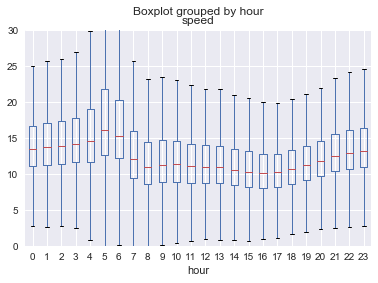

In [51]:
#get hour and plot boxplot by speed
data_['hour'] = data['lpep_pickup_datetime'].dt.hour
data_.boxplot('speed',by= 'hour')
plt.ylim(0,30)
plt.savefig('speedbyhour.jpeg')
plt.show()

In [52]:
hours = []
for i in range(24):
    hours.append( data_[data_['hour'] == i]['speed'])

In [53]:
print('pairs | F-score | p-value')
for i in range(len(hours)):
    for j in range(i+1,len(hours)):
        hours_ = "hour_"+str(i)+"_"+str(j)
        #getting F statistics and p value
        F, p = stats.f_oneway(hours[i], hours[j])
        print(hours_+' | '+str(F)+' | '+str(p))

pairs | F-score | p-value
hour_0_1 | 48.0662926705 | 4.14110924899e-12
hour_0_2 | 134.387713077 | 4.68903043073e-31
hour_0_3 | 366.087297623 | 1.87230672466e-81
hour_0_4 | 1146.98122035 | 6.7699118349e-250
hour_0_5 | 3384.19896524 | 0.0
hour_0_6 | 2266.09070717 | 0.0
hour_0_7 | 805.546135489 | 1.48804202192e-176
hour_0_8 | 4333.63823778 | 0.0
hour_0_9 | 3553.67741795 | 0.0
hour_0_10 | 3506.83081657 | 0.0
hour_0_11 | 4591.90665439 | 0.0
hour_0_12 | 5203.36530608 | 0.0
hour_0_13 | 5658.92660925 | 0.0
hour_0_14 | 9132.23067402 | 0.0
hour_0_15 | 12901.7712463 | 0.0
hour_0_16 | 15904.8363884 | 0.0
hour_0_17 | 17597.127358 | 0.0
hour_0_18 | 12770.22829 | 0.0
hour_0_19 | 8345.04739761 | 0.0
hour_0_20 | 4090.72487019 | 0.0
hour_0_21 | 1058.580778 | 2.05645229241e-231
hour_0_22 | 272.159584428 | 4.34198451228e-61
hour_0_23 | 54.5955000525 | 1.4885686164e-13
hour_1_2 | 24.2258254211 | 8.58194274173e-07
hour_1_3 | 159.754858722 | 1.3807801609e-36
hour_1_4 | 729.206431846 | 6.99756741898e-160
hour

hour_16_22 | 13696.8525989 | 0.0
hour_16_23 | 15572.1867979 | 0.0
hour_17_18 | 682.079237706 | 4.42739833463e-150
hour_17_19 | 2462.7503937 | 0.0
hour_17_20 | 5930.55796844 | 0.0
hour_17_21 | 11584.822504 | 0.0
hour_17_22 | 15180.0597323 | 0.0
hour_17_23 | 17246.5481282 | 0.0
hour_18_19 | 590.381274652 | 3.25347886004e-130
hour_18_20 | 2812.88247136 | 0.0
hour_18_21 | 7303.96100403 | 0.0
hour_18_22 | 10406.3042428 | 0.0
hour_18_23 | 12245.7609696 | 0.0
hour_19_20 | 848.29969781 | 4.46492086807e-186
hour_19_21 | 3860.29192546 | 0.0
hour_19_22 | 6238.95214609 | 0.0
hour_19_23 | 7730.60796743 | 0.0
hour_20_21 | 1098.4868942 | 3.85937673345e-240
hour_20_22 | 2507.45756901 | 0.0
hour_20_23 | 3508.26788776 | 0.0
hour_21_22 | 287.365970739 | 2.10514671516e-64
hour_21_23 | 693.511775517 | 1.58995016779e-152
hour_22_23 | 90.468520934 | 1.90353069609e-21


It is clear that the average trip speeds are materially the not same in all hours of September. But for some hours pairs, like hour 8 and 11, 9 and 10, 13 and 19,etc., the average speeds seem to come from the same distribution for those hour pairs. 

Accodrding to the boxplot, I may hypothesize that:
    The average trip speeds are materially the same in all hours of September, but some hours pairs share the same average speeds.
    

## Failed Attempts:
    1. I attempted to draw a geographic plot of pickup and dropoff points in the new york area, but failed due to some technical difficulty in installing the basemap library. I successfully installed the gmplot and imported, but the lib seemed to fail to load any of the city maps.
    2. I attempted to calculate the distance using the geodesic function, but it takes too long to compute the distance. 

## Future Improvement:
    1. Fix the library installation problem, and plot the distribution of trips in the NYC map. (Put blue as pickup and red as dropoff in the map, etc)
    2. Try other combinations of features to predict the tip percentage. For example, I may derive borough features from the latitude and longitude features instead of only using whether airports as a feature. Dive more into how a tip is caused, trying predicting tip amount.
    3. Explore the relationship between distance and other features to help taxi drivers earn more.

## Reference: 
    [1]feature description: https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf 
    [2]taxi fare: https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page
    [3]convert string to datetime: https://stackabuse.com/converting-strings-to-datetime-in-python/
    [4]distance calculation: https://stackoverflow.com/questions/34621118/distance-calculation-in-geopy
    [5]speed limits: https://en.wikipedia.org/wiki/Speed_limits_in_the_United_States
    [6]month of year: https://stackoverflow.com/questions/2600775/how-to-get-week-number-in-python
    [7]feature importance: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
       